# PastePicture2Wallpaper　

壁紙作成のための線画作成ツールです🎠

**GPUランタイムで実行してください**

<br>

処理手順
1. 深度閾値に従ってMidasを用いた単眼深度推定を行います
2. Canny法による線画抽出を行います(線画化過程でノイズ除去や線を太くするなどの処理を行っています)
3. OSの雰囲気に応じて半透明化した線画を出力します（result.pngという名前で出力されます）

<br>

🆕 : informative_drawingsが有効になりました。（デフォルト：True）

informative_drawingsはAIによって線画抽出を行います。

- median_k_sizeとmodeのオプションは無視されます。

<br>

以下のパラメータで値を弄ってください


<!-- - image_upload_option: 画像をアップロードする方法 -->
  <!-- - `Upload from device`: デバイスからアップロード -->
  <!-- - `URL`: URLからダウンロード -->
  <!-- - `Mount Drive`: Google Driveのマウントを行う -->
<!-- - path_or_url: ダウンロード先のURLかマウント先のデバイスのパスを指定(Upload from devieの場合は無視されます) -->
- mode: 線画処理のモード
  - Anime : アニメ風の輪郭がはっきりとしている画像向け
- OS: 壁紙のOSの種類によって出力される線画の雰囲気が少し変わります
  - Mac風(灰色):パステルカラーの背景に合わせて半透明の灰色線画を出力
  - Mac風(白色):鮮やかな背景に半透明の白線画を出力
  - Windows風: 水色の背景にさらに明るい水色半透明の線画を出力
  - Ubuntu風: 紫-桃色の背景に馴染む桃色半透明の線画を出力
- median_k_size: 細かなノイズを除去します。1の場合、無効化します。
- morph_g_ksize: モロフォジー変換用カーネルサイズ。膨張した画像と収縮した画像の差分をとる処理を行い、物体の輪郭を得ます。1の場合は無効化します。
- depth_threshold: 出力された深度情報をもとに線画化するための閾値



![](https://raw.githubusercontent.com/Ar-Ray-code/PastePicture2Wallpaper/main/images_for_readme/export-variation.png)

> デバイスからのアップロードのみ受け付けています
> 
> 直接URLを指定する場合は4番目のコードセルのURLを変更してコメントアウトを外し、以降のセルを実行（Ctrl+F10） を行ってください

In [1]:
# image_upload_option = 'Upload from device' #@param ["Upload from device", "URL", "Mount Drive"] {allow-input: true}
# path_or_url = "/content/sample.jpg"#@param {type:"string"}

mode = 'Anime' #@param ["Anime"] {allow-input: true}
OS =  'Mac-Gray' #@param ["Ubuntu","Windows","Mac-White","Mac-Gray"] {allow-input: true}
using_informative_drawings = "True" #@param ["True", "False"] {allow-input: true}
remove_back = 'ISNet' #@param ["ISNet", "Midas"]

# median_ksize=median_ksize, morph_g_ksize=morph_g_ksize

median_ksize = 5 #@param {type:"slider", min:1, max:9, step:2}
morph_g_ksize = 5 #@param {type:"slider", min:1, max:9, step:2}
depth_threshold = 150 #@param {type:"slider", min:0, max:255, step:1}
canny_threshold = 150 #@param {type:"slider", min:0, max:255, step:1}

default_picture = "True" #@param ["True", "False"] {allow-input: true}

In [2]:
print("mode=",mode)
print("OS=",OS)
print("using_informative_drawings=",using_informative_drawings)
print("remove_back=",remove_back)
print("median_ksize=",median_ksize)
print("morph_g_ksize=",morph_g_ksize)
print("depth_threshold=",depth_threshold)
print("canny_threshold=",canny_threshold)
print("default_picture=",default_picture)

mode= Anime
OS= Mac-Gray
using_informative_drawings= True
remove_back= ISNet
median_ksize= 5
morph_g_ksize= 5
depth_threshold= 150
canny_threshold= 150
default_picture= True


In [3]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=edc7fe659dfecde18ab938f67187e8d65e90b3f9c0c3a895a0f72cc42cabc8ee
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
!cd /content/
!rm /content/*.*g

rm: cannot remove '/content/*.*g': No such file or directory


In [5]:
# Upload from device
import os
if default_picture == "True":
    import wget
    os.chdir('/content/')
    url = 'https://s3.ap-northeast-1.wasabisys.com/download-raw/urara/album/urara-toresen.jpg'
    filename = wget.download(url)
else:
    from google.colab import files
    uploaded = files.upload()

#@markdown ### アップロードを (Choose Files)から行ってください
#@markdown Driveのマウントの場合はこのステップを飛ばして、新しくコードセルを作成して、`/content`に対象ファイルをコピーしてください

# from google.colab import drive
# drive.mount('/content/drive')

#@markdown <br>

#@markdown ### default_picture=Trueの場合
#@markdown - [urara-toresen.jpg](https://s3.ap-northeast-1.wasabisys.com/download-raw/urara/album/urara-toresen.jpg) がダウンロードされます。


In [6]:
#@markdown ###URLを指定する場合はこちらを編集し、upload.jpgで保存すること
# !rm sample.jpg
# !wget "https://drive.google.com/uc?export=download&id=1M1eDdinWr-aPT28cyOo01LlMFUnsBbRQ" -O upload.jpg

In [7]:
!ffmpeg -i *.*g -vf scale=-1:720 upload.jpg

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

In [8]:
!pip install tensorflow==2.8.0 tensorflow-hub==0.12.0 onnxruntime==1.15.0 onnx==1.14.0
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.2 MB/s eta 0:00:00
  Attempting uninsta

In [9]:
# DIS
! git clone https://github.com/xuebinqin/DIS
%cd /content/DIS/IS-Net

!mkdir saved_models

Cloning into 'DIS'...
remote: Enumerating objects: 328, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 328 (delta 64), reused 56 (delta 55), pack-reused 253
Receiving objects: 100% (328/328), 49.59 MiB | 23.02 MiB/s, done.
Resolving deltas: 100% (153/153), done.
/content/DIS/IS-Net


In [10]:
if remove_back=='ISNet':
    import cv2
    from data_loader_cache import normalize, im_reader, im_preprocess 
    import gdown
    from google.colab.patches import cv2_imshow
    from io import BytesIO
    import matplotlib.pyplot as plt
    from models import *
    import numpy as np
    import onnxruntime
    from PIL import Image
    import requests
    import torch
    from torch.autograd import Variable
    import torch.nn.functional as F
    from torchvision import transforms

    os.chdir('/content/DIS/IS-Net')
    device = 'cpu'
    gdown.download(
        'https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn', 
        './saved_models/isnet.pth', 
        quiet=False,
    )
    gdown.download(
        'https://drive.google.com/uc?id=1nV57qKuy--d5u1yvkng9aXW1KS4sOpOi', 
        './saved_models/isnet-general-use.pth', 
        quiet=False,
    )


    class GOSNormalize(object):
        '''
        Normalize the Image using torch.transforms
        '''
        def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
            self.mean = mean
            self.std = std

        def __call__(self,image):
            image = normalize(image,self.mean,self.std)
            return image
    
    def build_model(hypar,device):
        net = hypar["model"]#GOSNETINC(3,1)

        # convert to half precision
        if(hypar["model_digit"]=="half"):
            net.half()
            for layer in net.modules():
                if isinstance(layer, nn.BatchNorm2d):
                    layer.float()

        net.to(device)

        if(hypar["restore_model"]!=""):
            net.load_state_dict(torch.load(hypar["model_path"]+"/"+hypar["restore_model"],map_location=device))
            net.to(device)
        net.eval()  
        return net

    transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5],[1.0,1.0,1.0])])

    # gen param
    hypar = {} # paramters for inferencing

    hypar["model_path"] ="./saved_models" ## load trained weights from this path
    hypar["restore_model"] = "isnet-general-use.pth"  # "isnet.pth" ## name of the to-be-loaded weights
    hypar["interm_sup"] = False ## indicate if activate intermediate feature supervision

    ##  choose floating point accuracy --
    hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number
    hypar["seed"] = 0

    hypar["cache_size"] = [1024, 1024] ## cached input spatial resolution, can be configured into different size

    ## data augmentation parameters ---
    hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images
    hypar["crop_size"] = [1024, 1024] ## random crop size from the input, it is usually set as smaller than hypar["cache_size"], e.g., [920,920] for data augmentation

    hypar["model"] = ISNetDIS()

    net = build_model(hypar, device)



    def load_image(im_path, hypar):
        if im_path.startswith("http"):
            im_path = BytesIO(requests.get(im_path).content)

        im = im_reader(im_path)
        im, im_shp = im_preprocess(im, hypar["cache_size"])
        im = torch.divide(im,255.0)
        shape = torch.from_numpy(np.array(im_shp))
        return transform(im).unsqueeze(0), shape.unsqueeze(0) # make a batch of image, shape




        
    def predict(net,  inputs_val, shapes_val, hypar, device):
        '''
        Given an Image, predict the mask
        '''
        net.eval()

        if(hypar["model_digit"]=="full"):
            inputs_val = inputs_val.type(torch.FloatTensor)
        else:
            inputs_val = inputs_val.type(torch.HalfTensor)


        inputs_val_v = Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable

        ds_val = net(inputs_val_v)[0] # list of 6 results

        pred_val = ds_val[0][0,:,:,:] # B x 1 x H x W    # we want the first one which is the most accurate prediction

        ## recover the prediction spatial size to the orignal image size
        pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))

        ma = torch.max(pred_val)
        mi = torch.min(pred_val)
        pred_val = (pred_val-mi)/(ma-mi) # max = 1

        if device == 'cuda': torch.cuda.empty_cache()
        return (pred_val.detach().cpu().numpy()*255).astype(np.uint8) # it is the mask we need


    # ONNX convert
    def convert_to_onnx(net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
        input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

        input_layer_names = ['input_image']
        output_layer_names = ['output_image']

        torch.onnx.export(
            net, 
            input, 
            file_name, 
            verbose=True,
            opset_version=13,
            input_names=input_layer_names,
            output_names=output_layer_names,
        )

    convert_to_onnx(net, file_name='isnet-general-use.onnx', input_shape=(1024, 1024))


    # inference
    def run_inference(onnx_session, image, score_th=None):
        # ONNX Input Size
        input_size = onnx_session.get_inputs()[0].shape
        input_width = input_size[3]
        input_height = input_size[2]

        # Pre process:Resize, BGR->RGB, float32 cast
        input_image = cv2.resize(image, dsize=(input_width, input_height))
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        mean = [0.5, 0.5, 0.5]
        std = [1.0, 1.0, 1.0]
        input_image = (input_image / 255.0 - mean) / std
        input_image = input_image.transpose(2, 0, 1)
        input_image = np.expand_dims(input_image, axis=0)
        input_image = input_image.astype('float32')

        # Inference
        input_name = onnx_session.get_inputs()[0].name
        output_name = onnx_session.get_outputs()[0].name
        result = onnx_session.run([output_name], {input_name: input_image})

        # Post process:squeeze, Sigmoid, Normarize, uint8 cast
        mask = np.squeeze(result[0])
        min_value = np.min(mask)
        max_value = np.max(mask)
        mask = (mask - min_value) / (max_value - min_value)
        if score_th is not None:
            mask = np.where(mask < score_th, 0, 1)
        mask *= 255
        mask = mask.astype('uint8')

        return mask

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
Downloading...
From (uriginal): https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn
From (redirected): https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn&confirm=t&uuid=4a6276d9-44ab-4bf3-bb25-f4b558a3884d
To: /content/DIS/IS-Net/saved_models/isnet.pth
100%|██████████| 177M/177M [00:01<00:00, 140MB/s]
Downloading...
From (uriginal): https://drive.google.com/uc?id=1nV57qKuy--d5u1yvkng9aXW1KS4sOpOi
From (redirected): https://drive.google.com/uc?id=1nV57qKuy--d5u1yvkng9aXW1KS4sOpOi&confirm=t&uuid=24188bc1-5638-473d-a70a-1b1a241a4799
To: /content/DIS/IS-Net/saved_models/isnet-general-use.pth
100%|██████████| 177M/177M [00:01<00:00, 160MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3737: UserWarning: nn.functional.upsample is deprecated. Use n

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


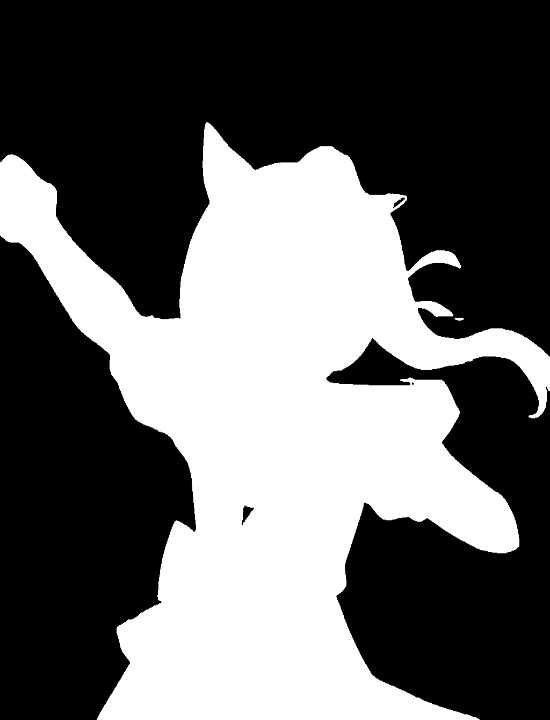

In [11]:
if remove_back=='ISNet':
    os.chdir('/content/DIS/IS-Net')
    image = cv2.imread('/content/upload.jpg')

    onnx_session = onnxruntime.InferenceSession(
        'isnet-general-use.onnx',
        providers=[
            'CUDAExecutionProvider',
            'CPUExecutionProvider',
        ],
    )
    mask = run_inference(
        onnx_session,
        image,
        score_th=0.5,
    )

    mask = cv2.resize(
        mask,
        dsize=(image.shape[1], image.shape[0]),
    )

    overlay_image = np.zeros(image.shape, dtype=np.uint8)
    overlay_image[:] = (255, 255, 255)
    data = np.stack((mask, ) * 3, axis=-1).astype('uint8')
    mask_image = np.where(data, image, overlay_image)

    # 表示
    cv2_imshow(data)
    data = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)

In [12]:
if remove_back=='Midas':
    import cv2
    import numpy as np

    import matplotlib.pyplot as plt
    import tensorflow_hub as hub
    import tensorflow as tf

    module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])
    model = module.signatures['serving_default']


    # 画像読み込み
    image = cv2.imread('/content/upload.jpg')

    # リサイズ
    resize_image = cv2.resize(image, (256, 256))

    # 正規化
    resize_image = cv2.cvtColor(resize_image, cv2.COLOR_BGR2RGB) / 255.0

    # 形状変更
    resize_image = resize_image.transpose(2, 0, 1)
    resize_image = resize_image.reshape(1, 3, 256, 256)

    # tensor形式へ変換
    tensor = tf.convert_to_tensor(resize_image, dtype=tf.float32)

    result = model(tensor)
    predict_result = result['default'].numpy()
    predict_result = np.squeeze(predict_result)

    # オリジナル画像のサイズにリサイズ
    predict_result = cv2.resize(predict_result, (image.shape[1], image.shape[0]))

    # 最大値が255になるよう変換
    depth_max = predict_result.max()
    data = ((predict_result / depth_max) * 255).astype(np.uint8)

    # カラーマップ画像へ変換
    color_map = cv2.applyColorMap(data, cv2.COLORMAP_TURBO)

    # 表示
    plt.imshow(color_map)

線画化

必ず実行

In [13]:
class image_utils:
    def median_filter(self, src, ksize):
        d = int((ksize-1)/2)
        h, w = src.shape[0], src.shape[1]
        dst = src.copy()

        for y in range(d, h - d):
            for x in range(d, w - d):
                dst[y][x] = np.median(src[y-d:y+d+1, x-d:x+d+1])
        return dst

    def export_edges_anime(self, image_raw: np.ndarray, depth_data: np.ndarray, median_ksize: int = 3, morph_g_ksize: int = 3, depth_threshold: int = 150, canny_threshold: int = 150):
        mask = depth_data > depth_threshold
        # maskを二値化
        mask = mask.astype(np.uint8) * 255
        # imageとmaskの合成
        result = cv2.bitwise_and(image_raw, image_raw, mask=mask)

        return self.anime2line(result, median_ksize=median_ksize, morph_g_ksize=morph_g_ksize, threshold=canny_threshold)

    def anime2line(self, image_raw: np.ndarray, median_ksize: int = 3, morph_g_ksize: int = 3, threshold: int = 150):
        edges = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)

        # Canny輪郭検出
        edges = cv2.Canny(edges, threshold, threshold)

        # MorphologyEx
        if morph_g_ksize == 1:
            pass
        else:
            kernel_giant = np.ones((morph_g_ksize, morph_g_ksize), np.uint8)
            edges = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel_giant)

        # 色の反転
        edges = cv2.bitwise_not(edges)
        edges = edges.astype(np.uint8) * 255 * 255
        edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

        # メディアンフィルタ
        if median_ksize == 1:
            pass
        else:
            edges = self.median_filter(edges, ksize=median_ksize)

        ret, output = cv2.threshold(edges, 200, 255, cv2.THRESH_BINARY)
        return edges

    # 白を透明にして色付きを半透明の白にする
    def white2transparent(self, input_image: np.ndarray, os_type: str = 'Ubuntu'):
        if os_type == 'Ubuntu':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 255
                        image_png[i][j][1] = 200
                        image_png[i][j][2] = 255
                        image_png[i][j][3] = 200
        elif os_type == 'Windows':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 200
                        image_png[i][j][1] = 255
                        image_png[i][j][2] = 255
                        image_png[i][j][3] = 200
        elif os_type == 'Mac-White':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 200
                        image_png[i][j][1] = 200
                        image_png[i][j][2] = 200
                        image_png[i][j][3] = 200
        elif os_type == 'Mac-Gray':
            image_png = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
            for i in range(image_png.shape[0]):
                for j in range(image_png.shape[1]):
                    if image_png[i][j][0] == 255 and image_png[i][j][1] == 255 and image_png[i][j][2] == 255:
                        image_png[i][j][3] = 0
                    else:
                        image_png[i][j][0] = 70
                        image_png[i][j][1] = 70
                        image_png[i][j][2] = 70
                        image_png[i][j][3] = 200
        else:
            print("cannot detect wallpaper OS")
        return image_png

線画化２

## Informative-drawings
ファイルのダウンロード作業。スキップするほどでもないですが、ダウンロードを行わない場合はこの工程をスキップしてください。

In [14]:
!git clone https://github.com/carolineec/informative-drawings
%cd informative-drawings

!mkdir checkpoints
!gdown 'https://drive.google.com/uc?id=11l5u5sb1PO5Z5YA3IoEHauVPm0k407C1'
!unzip model.zip -d checkpoints

Cloning into 'informative-drawings'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 101 (delta 21), reused 12 (delta 11), pack-reused 73
Receiving objects: 100% (101/101), 3.86 MiB | 23.64 MiB/s, done.
Resolving deltas: 100% (39/39), done.
/content/DIS/IS-Net/informative-drawings
Downloading...
From (uriginal): https://drive.google.com/uc?id=11l5u5sb1PO5Z5YA3IoEHauVPm0k407C1
From (redirected): https://drive.google.com/uc?id=11l5u5sb1PO5Z5YA3IoEHauVPm0k407C1&confirm=t&uuid=bee8b26b-d304-40db-bd8d-a50303b29175
To: /content/DIS/IS-Net/informative-drawings/model.zip
100% 47.7M/47.7M [00:00<00:00, 83.4MB/s]
Archive:  model.zip
   creating: checkpoints/model/
   creating: checkpoints/model/contour_style/
  inflating: checkpoints/model/contour_style/netG_A_latest.pth  
   creating: checkpoints/model/opensketch_style/
  inflating: checkpoints/model/opensketch_style/.DS_Store  
  inflating: c

In [15]:
import torch
from model import Generator

import onnxruntime
import cv2 as cv
import numpy as np

input_size = 512
# ドットアクセス用の辞書クラス
class DictDotNotation(dict): 
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.__dict__ = self
# 疑似的なコマンドライン引数生成

class InformativeDrawings:
    def create_options(self) -> DictDotNotation:
        opt = DictDotNotation()

        opt.name = 'model/anime_style'
        opt.dataroot = 'examples/test'
        opt.checkpoints_dir = 'checkpoints'
        opt.results_dir = 'results'
        opt.geom_name = 'feats2Geom'
        opt.batchSize = 1
        opt.depthroot = ''
        opt.input_nc = 3
        opt.output_nc = 1
        opt.geom_nc = 3
        opt.every_feat = 1
        opt.num_classes = 55
        opt.midas = 0
        opt.ngf = 64
        opt.n_blocks = 3
        opt.size = input_size
        opt.cuda = True
        opt.n_cpu = 8
        opt.which_epoch = 'latest'
        opt.aspect_ratio = 1.0
        opt.mode = 'test'
        opt.load_size = input_size
        opt.crop_size = input_size
        opt.max_dataset_size = float("inf")
        opt.preprocess = 'resize_and_crop'
        opt.no_flip = False
        opt.norm = 'instance'
        opt.predict_depth = 0
        opt.save_input = 0
        opt.reconstruct = 0
        opt.how_many = 100
        return opt

    def convert_to_onnx(self, net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
        input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

        input_layer_names = ['input_image']
        output_layer_names = ['output_image']

        torch.onnx.export(
            net, 
            input, 
            file_name, 
            verbose=True,
            opset_version=11,
            input_names=input_layer_names,
            output_names=output_layer_names,
        )
    
    def export_edges_anime(self, image_raw: np.ndarray, depth_data: np.ndarray, morph_g_ksize: int = 3, depth_threshold: int = 150) -> np.ndarray:
        mask = depth_data > depth_threshold
        # maskを二値化
        mask = mask.astype(np.uint8) * 255
        # imageとmaskの合成
        result = cv2.bitwise_and(image_raw, image_raw, mask=mask)

        return self.generate(result, morph_g_ksize)

    def generate(self, input_image, morph_g_ksize) -> np.ndarray:

        # ネットワーク生成
        opt = self.create_options()
        net_G = Generator(opt.input_nc, opt.output_nc, opt.n_blocks)

        # 重みをロード
        net_G.load_state_dict(torch.load(os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch)))
        device = 'cpu'
        net_G.eval().to(device)

        print('Loaded：', os.path.join(opt.checkpoints_dir, opt.name, 'netG_A_%s.pth' % opt.which_epoch))

        self.convert_to_onnx(net_G, 'anime_style_512x512.onnx', (input_size, input_size), device)

        # ONNXモデルロード
        onnx_session = onnxruntime.InferenceSession(
            'anime_style_512x512.onnx',
            providers=['CUDAExecutionProvider', 'CPUExecutionProvider'],
        )

        input_name = onnx_session.get_inputs()[0].name
        output_name = onnx_session.get_outputs()[0].name


        # 前処理 (input is image)
        image_data = cv.resize(input_image, dsize=(input_size, input_size))
        x = cv.cvtColor(image_data, cv.COLOR_BGR2RGB)

        x = np.array(x, dtype=np.float32)
        x = x.transpose(2, 0, 1)
        x = x.reshape(-1, 3, input_size, input_size)

        # 推論
        onnx_result = onnx_session.run([output_name], {input_name: x})

        # 後処理
        onnx_result = np.array(onnx_result).squeeze()
        onnx_result = onnx_result * 255
        onnx_result = onnx_result.astype(np.uint8)

        
        ret, output = cv2.threshold(onnx_result, 200, 255, cv2.THRESH_BINARY)

        # kernel_giant = np.ones((morph_g_ksize, morph_g_ksize), np.uint8)
        # output = cv2.morphologyEx(output, cv2.MORPH_GRADIENT, kernel_giant)

        output = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)
        output = cv2.resize(output, (image.shape[1],image.shape[0]))
        return output

In [16]:
image_utils_class = image_utils()

if using_informative_drawings == "True":
    print("using informative drawings...")
    id_class = InformativeDrawings()
    os.chdir('/content/DIS/IS-Net/informative-drawings/')
    image_line = id_class.export_edges_anime(image, depth_data=data, morph_g_ksize=morph_g_ksize, depth_threshold=depth_threshold)
else:
    print("using canny...")
    image_line = image_utils_class.export_edges_anime(image_raw=image, depth_data=data, median_ksize=median_ksize, morph_g_ksize=morph_g_ksize, depth_threshold=depth_threshold, canny_threshold=canny_threshold)
#@markdown ## export_edges_anime関数
#@markdown ### 引数一覧
#@markdown - image_raw: 画像（読み込み時のまま）
#@markdown - depth_data: 深度データ(2次元のndarray・0~255)
#@markdown - threshold: 深度の閾値（0~255・int型）
#@markdown
#@markdown ### 出力一覧
#@markdown - image: マスク済み画像
#@markdown
#@markdown ### 分岐
#@markdown - informative drawings をTrueに設定するとAI線画に、FalseにするとCanny線画になります。

using informative drawings...
Loaded： checkpoints/model/anime_style/netG_A_latest.pth


/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/jit_utils.py:306: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.10/dist-packages/torch/onnx/symbolic_helper.py:1466: UserWarning: ONNX export mode is set to TrainingMode.EVAL, but operator 'instance_norm' is set to train=True. Exporting with train=True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:689: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at ../torch/csrc/jit/passes/onnx/constant_fold.cpp:179.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:1186: UserWarning: C

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [17]:
image_png = image_utils_class.white2transparent(image_line, OS)

#@markdown ## white2transparent関数
#@markdown 白領域を透明化する関数（色付きは半透明の白になります）

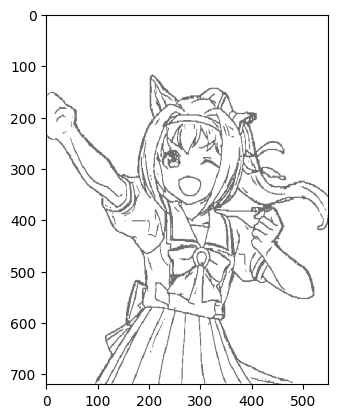

In [18]:
plt.imshow(image_png)

In [19]:
plt.imsave("/content/result.png",image_png)
from google.colab import files
files.download('/content/result.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# Export depth
#@markdown convert.pyで深度情報を確認する時はこのセルを実行して`depth_result.png`をダウンロードします。

# # v----この行以下をコメントアウト--------v
# export_png = np.zeros((data.shape[0], data.shape[1], 3))
# export_png[:,:,0] = data/255
# export_png[:,:,1] = data/255
# export_png[:,:,2] = data/255

# plt.imsave("/content/depth_result.png",export_png)
# files.download('/content/depth_result.png')